# Konvolucijske neuronske mreže (CNN)

Osnovni pojmovi kod konvolucijskih neuronskih mreža:
 - Konvolucija
 - Sažimanje (pooling)

In [1]:
## Importing useful libraries
import os
import math
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision

import matplotlib.pyplot as plt
from imageio.v2 import imread
%matplotlib inline

from tqdm.notebook import tqdm

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


### Konvolucija*

Konvolucija u neuronskim mrežama je matematička operacija koja prima dva skupa podataka, ulazni skup (sliku ili značajke) i filter (kernel).

Filter je 2D matrica realnih brojeva. Filter se primjenjuje na gornji lijevi kut ulaznog skupa, pomiče se određeni broj elemenata u desno, to se ponavlja do kraja retka, pa se pomiče prema dolje itd. Filter se primjenjuje na način da se svaki element filtera pomnoži s *preklopljenim* elementom ulaznog skupa te se tako dobiveni brojevi zbroje. Taj novi broj je jedan element izlaznog skupa podataka. Filter se uči za vrijeme treniranja konvolucijske neuronske mreže.

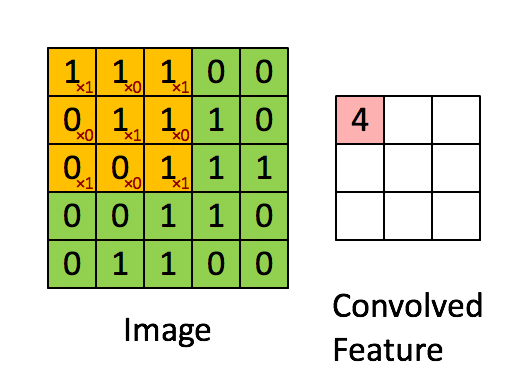






**Ovdje se radi o 2D konvoluciji, ali slični pojmovi i operacije se mogu primijeniti i kod 3D konvolucija*.

Postoje razni parametri konvolucijskih slojeva u neuronskim mrežama. U nastavku su nabrojani neki od njih, a o ostalima možete pročitati [ovdje](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html).

- broj ulaznih kanala (*in_channels*) - broj kanala ulazne slike/značajki, primjerice 3 za slučaj RGB slike
- broj izlaznih kanala (*out_channels*)
- veličina kernela/filtera (*kernel_size*) - dimenzije kernela
- *stride* - broj piksela koliko se kernel pomiče pri konvoluciji
- *padding* - broj piksela koji se dodaju na rub ulaznih podataka

Probajmo primijeniti konvoluciju na nekakvu sliku.

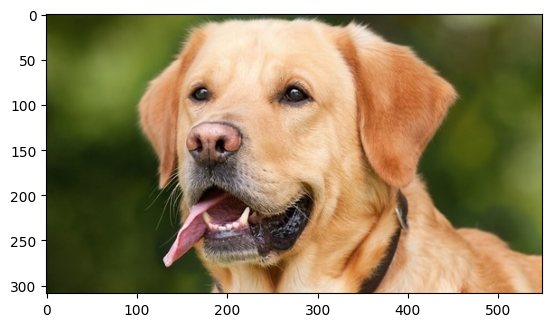

In [3]:
link = "https://www.hindustantimes.com/ht-img/img/2023/08/25/550x309/international_dog_day_1692974397743_1692974414085.jpg"
input_image = imread(link)
plt.imshow(input_image)
plt.show()

In [4]:
transform = transforms.Compose([
    transforms.ToTensor()
])
input_tensor = transform(input_image)

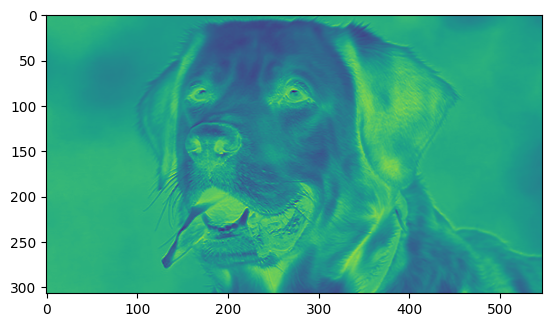

In [5]:
convolution = nn.Conv2d(3, 1, 3)
out = convolution(input_tensor)
out_image = out.detach().numpy().transpose(1, 2, 0)
plt.imshow(out_image)
plt.show()

Gore je prikazan izlaz iz konvolucije nasumičnih filtera, možemo ispisati te filtere. Također možemo i napraviti svoje filtere te ih primijeniti na ulaznu sliku.

In [6]:
convolution.weight

Parameter containing:
tensor([[[[ 0.0732,  0.1267, -0.0688],
          [ 0.0691, -0.0407, -0.0062],
          [-0.0030,  0.0746,  0.1708]],

         [[-0.0236, -0.1879, -0.0940],
          [ 0.0146, -0.0639, -0.1823],
          [-0.0305,  0.1041, -0.0543]],

         [[ 0.0103, -0.0335, -0.0019],
          [-0.0779, -0.1172, -0.1561],
          [-0.0641,  0.0360,  0.0885]]]], requires_grad=True)

In [7]:
our_kernel = [[[[-1, 0, 1],
                [-2, 0, 2],
                [-1, 0, 1]],
               [[-1, 0, 1],
                [-2, 0, 2],
                [-1, 0, 1]],
               [[-1, 0, 1],
                [-2, 0, 2],
                [-1, 0, 1]]]]
our_kernel = nn.Parameter(torch.Tensor(our_kernel))
convolution.weight = our_kernel

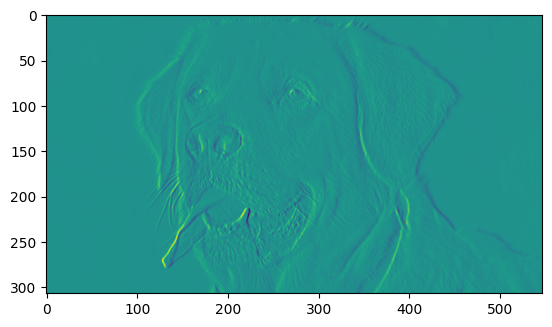

In [8]:
out = convolution(input_tensor)
out_image = out.detach().numpy().transpose(1, 2, 0)
plt.imshow(out_image)
plt.show()

Možemo primijetiti da smo pomoću gore definiranog filtera detektirali vertikalne rubove na ulaznoj slici.

### Sažimanje

Sloj sažimanja (*pooling layer*) sažima ulazne podatke te im tako smanjuje dimenzije. Primjenjuje se u konvolucijskim neuronskim mrežama nakon jednog ili više konvolucijskih slojeva. Postoje [razni](https://pytorch.org/docs/stable/nn.html#pooling-layers) načini sažimanja, ali najčešći je [*max pooling*](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d).

*Max pooling* jednostavno uzima određeni segment ulazne matrice i bira najveću vrijednost koja se upisuje u izlaznu matricu. *Max pooling* sloj ima nekoliko parametara, a neki od njih su:
 - `kernel_size` - veličina prozora (kernela), može biti jedan broj ili *tuple*
 - `stride` - broj piksela koliko se prozor pomiče, može biti jedan broj ili *tuple*, zadano je da je jednako veličini prozora

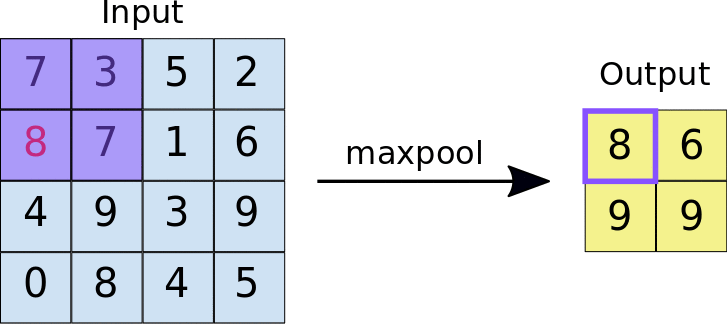

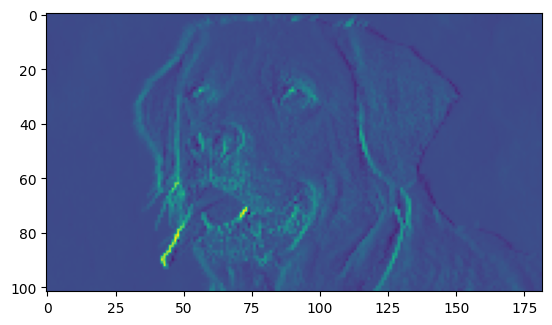

In [9]:
## TODO
## Implement the max pooling layer and use it on the above image of edges
## Check the input and output shapes and how they differ depending on the
## max pooling kernel size

pool = nn.MaxPool2d((3, 3))
pooled = pool(out)
pooled_image = pooled.detach().numpy().transpose(1,2,0)
plt.imshow(pooled_image)
plt.show()

### Konvolucijska neuronska mreža

Standardna konvolucijska mreža je kombinacija 3 vrste slojeva:
 - Konvolucijski slojevi
 - Slojevi sažimanja
 - Potpuno povezani slojevi

Naravno, primjenjuju se razne aktivacijske funkcije nakon konvolucijskih i potpuno povezanih slojeva. Također se koriste i drugi slojevi, koje ćemo odraditi u budućim LV-ovima, povratne veze itd.

CNN-ovi su često izgrađeni na način da se nizaju konvolucijski slojevi popraćeni slojem sažimanja, zatim se opet nizaju konvolucijski slojevi popraćeni slojem sažimanja, što se ponavlja određeni broj puta te se na kraju izlaz iz posljednjeg sloja sažimanja provlači kroz potpuno povezane slojeve. Primjer ovakve jedne mreže (VGG-16) je prikazan na slici. Na ovom primjeru je jasno vidljivo kako se prve dvije dimenzije podataka smanjuju prolaskom kroz mrežu, a treća dimenzija, broj kanala, se povećava. Također je važno naglasiti da je, prije dodavanja potpuno povezanih slojeva, potrebno dodati [sloj za izravnavanje (*flatten*)](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html).

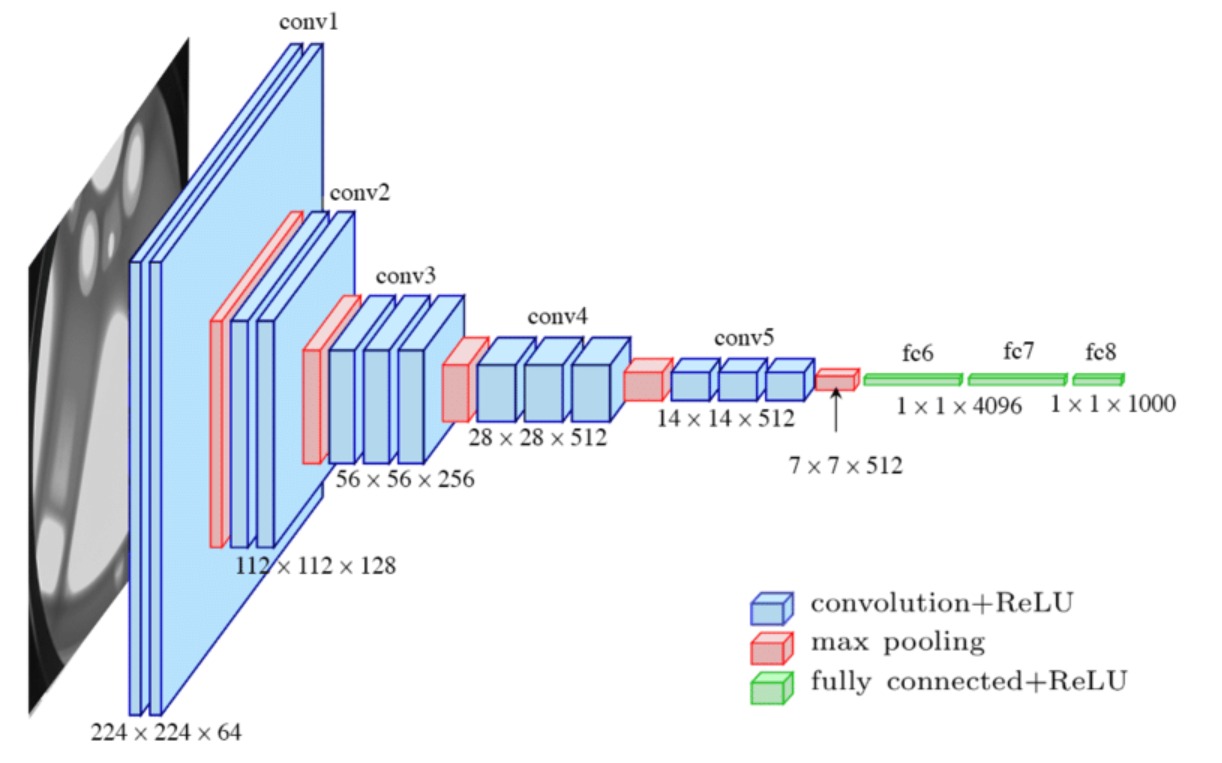

## Zadatak

Potrebno je izraditi i istrenirati konvolucijsku neuronsku mrežu na CIFAR-10 podatkovnom skupu.

CIFAR-10 je podatkovni skup koji se sastoji od 60000 slika u boji veličine 32x32. Svaka od ovih slika je klasificirana u jednu od 10 klasa. Podatkovni skup je podijeljen na skup za treniranje (50000 slika) i skup za testiranje (10000). Potrebno je skup za treniranje dodatno podijeliti na skup za treniranje (40000) i skup za validaciju (10000). Ovo možete učiniti pomoću sljedeće naredbe:

`trainset, valset = torch.utils.data.random_split(whole_trainset, [50000, 10000])`

Taj [podatkovni skup](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html) se može vrlo lagano dohvatiti pomoću *torchvision* biblioteke.

In [10]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 512

whole_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
## TODO
## divide the trainset into trainset and valset
## containing 40000 and 10000 images respectively

trainset, valset = torch.utils.data.random_split(whole_trainset, [40000, 10000])

# Loader for training data
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# Loader for validation data
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# Loader for testing data
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:06<00:00, 28373668.24it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


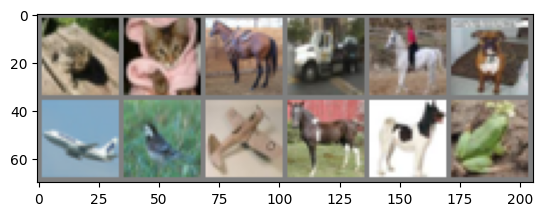

frog  cat   horse truck horse dog   plane bird  plane horse dog   frog 


In [11]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

images = images[:12]
labels = labels[:12]

# show images
imshow(torchvision.utils.make_grid(images, nrow=6))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(12)))

#### Mreža

Implementirajte neuronsku mrežu koja se sastoji od tri konvolucijska sloja, svaki od kojih je popraćen ReLU aktivacijskom funckijom i *max pooling* slojem. Za *max pooling* koristite kernel veličine 2x2. Brojeve filtera u konvolucijskim slojevima odaberite proizvoljno (nemojte odabrati prevelike brojeve za ovaj zadatak).

Svi konvolucijski slojevi koriste sljedeće parametre:
 - Veličina filtera (kernela): 3x3
 - *stride*: 1
 - *padding*: 'same'

Nakon konvolucijskih slojeva, dodajte tri potpuno povezana sloja s proizvoljnim brojem neurona. Napomena: Posljednji sloj treba imati 10 izlaza za 10 klasa i ne treba imati aktivacijsku funkciju.

Mreža će se koristiti za rad na podatkovnom skupu koji sadrži slike veličine 32x32, stoga prilagodite potpuno povezane slojeve tim dimenzijama.



In [12]:
## TODO
## Implement the convolutional neural network

class CNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d((2, 2))
        self.flatten = nn.Flatten()

        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding='same')
        self.cnn2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding='same')
        self.cnn3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same')
        self.cnn4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding='same')
        self.cnn5 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding='same')
        self.cnn6 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding='same')
        self.cnn7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding='same')
        self.cnn8 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding='same')
        self.cnn9 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding='same')
        self.cnn10 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding='same')
        self.cnn11 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding='same')

        self.linear1 = nn.Linear(2048, 340)
        self.linear2 = nn.Linear(340, 56)
        self.linear3 = nn.Linear(56, 10)

    def forward(self, x):
        out = self.cnn1(x)
        out = self.relu(out)
        out = self.cnn2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.cnn3(out)
        out = self.relu(out)
        out = self.cnn4(out)
        out = self.relu(out)
        out = self.cnn5(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.cnn6(out)
        out = self.relu(out)
        out = self.cnn7(out)
        out = self.relu(out)
        out = self.cnn8(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.cnn9(out)
        out = self.relu(out)
        out = self.cnn10(out)
        out = self.relu(out)
        out = self.cnn11(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.flatten(out)
        out = self.linear1(out)
        out = self.linear2(out)
        out = self.linear3(out)
        return out

model = CNN()
model = model.to(torch.device("cuda"))
print(model)

CNN(
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (cnn1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (cnn2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (cnn3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (cnn4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (cnn5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (cnn6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (cnn7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (cnn8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (cnn9): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (cnn10): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (cnn11): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
  

Nakon što ste definirali mrežu i podatkovne skupove za treniranje i testiranje, vrijeme je za treniranje mreže. Primijenite znanja stečena u prvoj laboratorijskoj vježbi kako biste istrenirali VGG-16 neuronsku mrežu na CIFAR-10 podatkovnom skupu. Za funkciju gubitka koristite [gubitak unakrsne entropije (*cross-entropy loss*)](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

In [13]:
## TODO
## Define the loss function and the optimizer
loss_module = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

Za razliku od prve vježbe, ovdje je potrebno dodati i kontinuirano praćenje vrijednosti funkcije gubitka na skupovima za treniranje i validaciju po epohama. Kako biste ovo postigli, možete kumulativno zbrajati vrijednost funkcije gubitka u svakoj iteraciji treniranja.

Prilikom treninga, na kraju svake epohe izračunajte točnost modela na skupovima za treniranje i validaciju. Hint: Koristite istu funkciju za izračun vrijednosti funkcije gubitka (loss) i za točnost na validacijskom skupu.

Ove vrijednosti možete odmah ispisivati na ekran, ali je bitno da ih spremite u varijable kojima ćete moći poslije pristupiti zbog vizualizacije i analize (možete te varijable vratiti kao izlaze iz funkcije za treniranje).

Koristite tqdm za praćenje tijeka treniranja za svaku epohu posebno (za razliku od praćenja tijeka treniranja za sve epohe zajedno). To možete učiniti na sljedeći način:

`for data_inputs, data_labels in tqdm(data_loader, 'Epoch %d'%(epoch + 1)):`,

gdje je `epoch` broj epohe za koju se ispisuje tijek.


In [14]:
def eval_model(model, val_data_loader, loss_module):
    model.eval() # Set model to eval mode
    true_preds, num_preds = 0., 0.

    ## TODO
    ## Calculate loss for the whole dataset
    eval_loss = 0.0
    with torch.no_grad(): # Deactivate gradients for the following code
        for data_inputs, data_labels in val_data_loader:

            # Determine prediction of model on dev set
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            preds = model(data_inputs)
            _, pred_labels = torch.max(preds.data, dim=1) # Binarize predictions to 0 and 1

            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_labels).sum().item()
            num_preds += data_labels.shape[0]
            loss = loss_module(preds, data_labels)
            eval_loss += loss.item() * len(data_inputs)

    eval_loss /= len(val_data_loader.dataset)
    eval_acc = true_preds / num_preds
    print(f"Accuracy of the model: {100.0*eval_acc:4.2f}%")
    ## TODO
    ## Return the accuracy and the loss
    return eval_acc, eval_loss

In [15]:
## TODO
## Train the network
def train_model(model, optimizer, train_data_loader, val_data_loader, loss_module, num_epochs=100):
    # Set model to train mode
    model.train()
    acc_train = np.zeros(num_epochs)
    loss_train = np.zeros(num_epochs)
    acc_eval = np.zeros(num_epochs)
    loss_eval = np.zeros(num_epochs)

    # Training loop
    for epoch in range(num_epochs):
        true_preds, num_preds = 0., 0.
        epoch_loss = 0.0
        for data_inputs, data_labels in tqdm(train_data_loader, 'Epoch %d'%(epoch + 1)):

            ## Step 1: Move input data to device
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)

            ## Step 2: Run the model on the input data
            preds = model(data_inputs)
            _, pred_labels = torch.max(preds.data, dim=1) # Binarize predictions to 0 and 1
            true_preds += (pred_labels == data_labels).sum().item()
            num_preds += data_labels.shape[0]

            ## Step 3: Calculate the loss
            loss = loss_module(preds, data_labels)

            ## Step 4: Perform backpropagation
            optimizer.zero_grad()
            # Perform backpropagation
            loss.backward()

            ## Step 5: Update the parameters
            optimizer.step()

            epoch_loss += loss.item() * len(data_inputs)
        ## TODO
        ## Calculate loss and accuracy for both datasets
        ## Store the accuracies and losses for both datasets
        acc_eval[epoch], loss_eval[epoch] = eval_model(model, val_data_loader, loss_module)
        epoch_loss /= len(train_data_loader.dataset)
        loss_train[epoch] = epoch_loss
        acc_train[epoch] = true_preds / num_preds

        model.train()

    return acc_train, loss_train, acc_eval, loss_eval

In [16]:
def visualize_training(train_loss, val_loss, train_acc, val_acc):
  plt.figure(figsize=[4,3])
  plt.plot(train_loss,'r',linewidth=1.0)
  plt.plot(val_loss,'b',linewidth=1.0)
  plt.legend(['Training loss', 'Validation Loss'],fontsize=8)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Loss',fontsize=16)
  plt.title('Loss Curves',fontsize=16)

  # Accuracy Curves
  plt.figure(figsize=[4,3])
  plt.plot(train_acc,'r',linewidth=1.0)
  plt.plot(val_acc,'b',linewidth=1.0)
  plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=8)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Accuracy',fontsize=16)
  plt.title('Accuracy Curves',fontsize=16)

  plt.show()

Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Accuracy of the model: 21.72%


Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Accuracy of the model: 30.00%


Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Accuracy of the model: 34.25%


Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Accuracy of the model: 48.93%


Epoch 5:   0%|          | 0/79 [00:00<?, ?it/s]

Accuracy of the model: 56.72%


Epoch 6:   0%|          | 0/79 [00:00<?, ?it/s]

Accuracy of the model: 61.96%


Epoch 7:   0%|          | 0/79 [00:00<?, ?it/s]

Accuracy of the model: 62.48%


Epoch 8:   0%|          | 0/79 [00:00<?, ?it/s]

Accuracy of the model: 68.56%


Epoch 9:   0%|          | 0/79 [00:00<?, ?it/s]

Accuracy of the model: 69.68%


Epoch 10:   0%|          | 0/79 [00:00<?, ?it/s]

Accuracy of the model: 69.05%


Epoch 11:   0%|          | 0/79 [00:00<?, ?it/s]

Accuracy of the model: 70.58%


Epoch 12:   0%|          | 0/79 [00:00<?, ?it/s]

Accuracy of the model: 74.74%


Epoch 13:   0%|          | 0/79 [00:00<?, ?it/s]

Accuracy of the model: 72.51%


Epoch 14:   0%|          | 0/79 [00:00<?, ?it/s]

Accuracy of the model: 71.05%


Epoch 15:   0%|          | 0/79 [00:00<?, ?it/s]

Accuracy of the model: 72.95%


Epoch 16:   0%|          | 0/79 [00:00<?, ?it/s]

Accuracy of the model: 74.41%


Epoch 17:   0%|          | 0/79 [00:00<?, ?it/s]

Accuracy of the model: 73.96%


Epoch 18:   0%|          | 0/79 [00:00<?, ?it/s]

Accuracy of the model: 76.18%


Epoch 19:   0%|          | 0/79 [00:00<?, ?it/s]

Accuracy of the model: 77.04%


Epoch 20:   0%|          | 0/79 [00:00<?, ?it/s]

Accuracy of the model: 73.95%


Epoch 21:   0%|          | 0/79 [00:00<?, ?it/s]

Accuracy of the model: 75.95%


Epoch 22:   0%|          | 0/79 [00:00<?, ?it/s]

Accuracy of the model: 75.32%


Epoch 23:   0%|          | 0/79 [00:00<?, ?it/s]

Accuracy of the model: 75.41%


Epoch 24:   0%|          | 0/79 [00:00<?, ?it/s]

Accuracy of the model: 75.11%


Epoch 25:   0%|          | 0/79 [00:00<?, ?it/s]

Accuracy of the model: 76.47%


Epoch 26:   0%|          | 0/79 [00:00<?, ?it/s]

Accuracy of the model: 76.68%


Epoch 27:   0%|          | 0/79 [00:00<?, ?it/s]

Accuracy of the model: 76.25%


Epoch 28:   0%|          | 0/79 [00:00<?, ?it/s]

Accuracy of the model: 76.83%


Epoch 29:   0%|          | 0/79 [00:00<?, ?it/s]

Accuracy of the model: 75.69%


Epoch 30:   0%|          | 0/79 [00:00<?, ?it/s]

Accuracy of the model: 76.52%


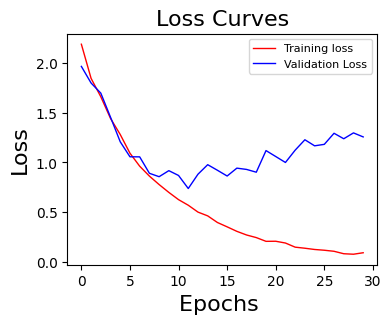

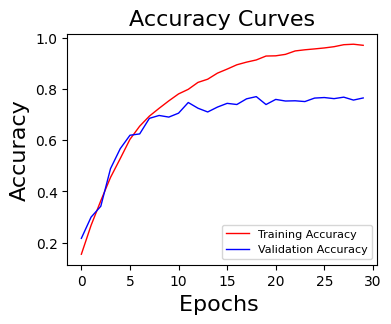

In [17]:
## TODO
## Visualize the loss and accuracy throughout the training process

acc_train, loss_train, acc_eval, loss_eval = train_model(model, optimizer, trainloader, valloader, loss_module, 30)
visualize_training(loss_train, loss_eval, acc_train, acc_eval)

Istestirajte istreniranu neuronsku mrežu na skupu za testiranje, ispišite ukupnu točnost i vizualizirajte neke od predikcija.

Bird 70 was recognized as a plane


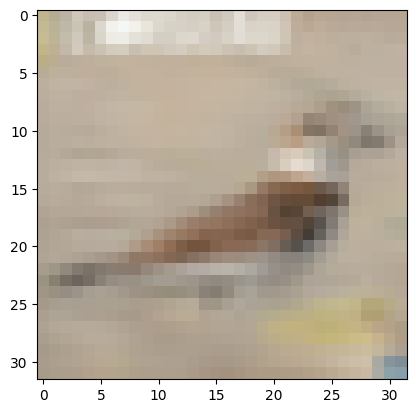

Plane 269 was recognized as a bird


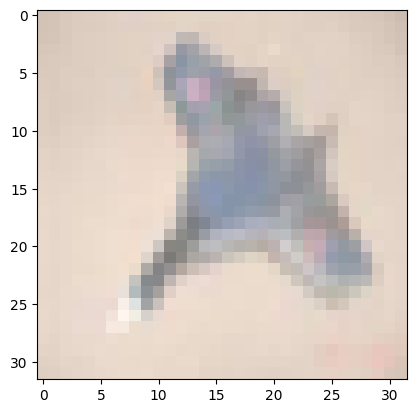

Accuracy of the model: 75.08%


In [18]:
## TODO
## Test the network

model.eval()
true_preds, num_preds = 0., 0.
birdFlag = True
planeFlag = True

for data_inputs, data_labels in testloader:

    # Determine prediction of model on dev set
    data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
    preds = model(data_inputs)
    _, pred_labels = torch.max(preds.data, dim=1) # Binarize predictions to 0 and 1

    # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
    true_preds += (pred_labels == data_labels).sum().item()
    num_preds += data_labels.shape[0]

    if birdFlag or planeFlag:
      pred_labels = pred_labels.to(torch.device("cpu"))
      data_labels = data_labels.to(torch.device("cpu"))
      data_inputs = data_inputs.to(torch.device("cpu"))

    # Visualize a bird mistaken for a plane
    if birdFlag:
      real_birds = np.where(data_labels == torch.tensor(2))[0]
      pred_planes = np.where(pred_labels == torch.tensor(0))[0]
      for bird in real_birds:
        for plane in pred_planes:
          if bird == plane and birdFlag:
            print("Bird "+str(bird)+" was recognized as a plane")
            imshow(data_inputs[bird])
            birdFlag = False

    # Visualize a plane mistaken for a bird
    if planeFlag:
      real_planes = np.where(data_labels == torch.tensor(0))[0]
      pred_birds = np.where(pred_labels == torch.tensor(2))[0]
      for plane in real_planes:
        for bird in pred_birds:
          if bird == plane and planeFlag:
            print("Plane "+str(bird)+" was recognized as a bird")
            imshow(data_inputs[bird])
            planeFlag = False

acc = true_preds / num_preds
print(f"Accuracy of the model: {100.0*acc:4.2f}%")